In [1]:
import pandas as pd
df_train = pd.read_csv("../dataset/train_data.csv")
df_test = pd.read_csv("../dataset/test_data.csv")
df_val = pd.read_csv("../dataset/val_data.csv")
df_train, df_test, df_val

(                                                 berita  label
 0     independensi hakim disorot putusan mk batas us...      0
 1     bantu ekonomi rakyat, raffi ahmad buka situs judi      1
 2     ombudsman panggil bey machmudin insiden relawa...      0
 3               perundungan perbaikan kurikulum merdeka      0
 4     jokowi temui pangeran arab saudi, teken kerja ...      0
 ...                                                 ...    ...
 4279  kadiv humas polri ingatkan jaga persatuan pemi...      0
 4280                  'dbon membuahkan hasil, dilanjut'      0
 4281                  verifikasi parpol tingkat dpw dpc      0
 4282       golkar jakarta resmi rekomendasi dukung ahok      0
 4283              lowongan kerja pt telkom agustus 2024      1
 
 [4284 rows x 2 columns],
                                                  berita  label
 0           anies dukungan ridwan kamil pilkada jakarta      1
 1     coca-cola ulang tahun, bagi-bagi rp10 juta rat...      1
 2          

In [2]:
train_text = df_train["berita"].tolist()
train_label = df_train["label"].tolist()
test_text = df_test["berita"].tolist()
test_label = df_test["label"].tolist()
val_text = df_val["berita"].tolist()
val_label = df_val["label"].tolist()

### IndoBERT model without fine-tuning

In [4]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertForSequenceClassification, BertTokenizer

# Load the IndoBERT model without fine-tuning
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2", num_labels=2)
test_tokenized_text = tokenizer(test_text, padding=True, truncation=True, max_length=512)
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

# Function to evaluate the model on the test dataset
with torch.no_grad():
    input_ids = torch.tensor(test_tokenized_text["input_ids"]).to(device)
    attention_mask = torch.tensor(test_tokenized_text["attention_mask"]).to(device)
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

# Evaluate the model
accuracy = accuracy_score(test_label, predictions)
precision = precision_score(test_label, predictions, average='weighted', zero_division=1)
recall = recall_score(test_label, predictions, average='weighted', zero_division=1)
f1 = f1_score(test_label, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.0564
Precision: 0.8318
Recall: 0.0564
F1-Score: 0.0974


### IndoBERT model fine-tuned with dataset

In [3]:
from transformers import BertForSequenceClassification, BertTokenizer
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2", num_labels=2)
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2")

c:\Users\screm\anaconda3\envs\fndindobert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
model.config.hidden_dropout_prob = 0.6
model.config.attention_probs_dropout_prob = 0.6
model.classifier.dropout = 0.5

In [ ]:
# token untuk train dan test
train_tokenized_text = tokenizer(train_text, padding=True, truncation=True, max_length=512)
test_tokenized_text = tokenizer(test_text, padding=True, truncation=True, max_length=512)
val_tokenized_text = tokenizer(val_text, padding=True, truncation=True, max_length=512)

In [6]:
import torch

# konversi ke tensor
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_tokenized_text["input_ids"]), 
    torch.tensor(train_tokenized_text["attention_mask"]),
    torch.tensor(train_label))

test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_tokenized_text["input_ids"]), 
    torch.tensor(test_tokenized_text["attention_mask"]),
    torch.tensor(test_label))

val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_tokenized_text["input_ids"]), 
    torch.tensor(val_tokenized_text["attention_mask"]),
    torch.tensor(val_label))

In [7]:
# memakai CUDA untuk mempercepat training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
import torch
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

def train_bert_classifier(
    model, 
    device,
    epochs=10, 
    batch_size=64, 
    learning_rate=2e-6, 
    patience=3, 
    n_splits=3, 
    early_stopping_metric='f1'
):
    """
    Train a BERT classifier with advanced early stopping and model checkpointing
    
    Parameters:
    - model: Pre-configured BERT model
    - device: Training device (cuda/cpu)
    - train_dataset: Training dataset
    - val_dataset: Validation dataset
    - epochs: Maximum training epochs
    - batch_size: Batch size for training
    - learning_rate: Learning rate for optimizer
    - patience: Number of epochs to wait for improvement
    - n_splits: Number of cross-validation folds
    - early_stopping_metric: Metric to use for early stopping ('f1', 'accuracy', 'loss')
    
    Returns:
    - Dictionary of average metrics across folds
    """
    kf = KFold(n_splits=n_splits)
    all_metrics = []

    for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):
        print(f"Fold {fold + 1}/{n_splits}")

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer, 
            num_warmup_steps=total_steps // 10, 
            num_training_steps=total_steps
        )

        best_metric_value = float('-inf') if early_stopping_metric != 'loss' else float('inf')
        epochs_no_improve = 0
        best_model_state = None
        metrics = {
            'train_loss': [], 'train_acc': [], 'train_f1': [], 
            'test_loss': [], 'test_acc': [], 'test_f1': [],
            'val_loss': [], 'val_acc': [], 'val_f1': []
        }

        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            model.train()
            total_loss = 0
            predictions = []
            true_labels = []

            progress_bar = tqdm(train_loader, desc="Training")

            for batch in progress_bar:
                batch = tuple(t.to(device) for t in batch)
                input_ids, attention_mask, labels = batch

                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()

                total_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

                progress_bar.set_postfix(loss=loss.item())

            train_loss = total_loss / len(train_loader)
            train_acc = accuracy_score(true_labels, predictions)
            train_f1 = f1_score(true_labels, predictions, average='weighted')

            metrics['train_loss'].append(train_loss)
            metrics['train_acc'].append(train_acc)
            metrics['train_f1'].append(train_f1)

            val_loss, val_acc, val_f1 = evaluate(model, val_loader, device)
            metrics['val_loss'].append(val_loss)
            metrics['val_acc'].append(val_acc)
            metrics['val_f1'].append(val_f1)

            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

            # Determine early stopping metric dynamically
            current_metric_value = {
                'f1': val_f1,
                'accuracy': val_acc,
                'loss': val_loss
            }[early_stopping_metric]

            is_improvement = (
                (early_stopping_metric != 'loss' and current_metric_value > best_metric_value) or
                (early_stopping_metric == 'loss' and current_metric_value < best_metric_value)
            )

            if is_improvement:
                best_metric_value = current_metric_value
                epochs_no_improve = 0
                best_model_state = model.state_dict().copy()
                torch.save(model.state_dict(), "indobertModel.pt")
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

        # Restore best model if checkpointed
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        all_metrics.append(metrics)

    avg_metrics = {key: np.mean([m[key] for m in all_metrics], axis=0) for key in metrics.keys()}
    print(f"Average metrics across {n_splits} folds: {avg_metrics}")

    return avg_metrics

def evaluate(model, dataloader, device):
    """
    Evaluate model performance on a given dataloader
    
    Parameters:
    - model: Trained model
    - dataloader: Validation/Test dataloader
    - device: Device to run evaluation on
    
    Returns:
    - Tuple of (loss, accuracy, f1_score)
    """
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy, f1

In [10]:
metrics = train_bert_classifier(
    model=model,
    device=device,
    epochs=8,
    batch_size=64,
    learning_rate=2e-6,
    patience=3,
    n_splits=2
)

Fold 1/2

Epoch 1/8


Training:   0%|          | 0/67 [00:00<?, ?it/s]c:\Users\screm\anaconda3\envs\fndindobert\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Training: 100%|██████████| 67/67 [00:57<00:00,  1.17it/s, loss=0.708]


Train Loss: 1.2986, Train Acc: 0.4211, Train F1: 0.4769
Val Loss: 0.6771, Val Acc: 0.7549, Val F1: 0.7528

Epoch 2/8


Training: 100%|██████████| 67/67 [00:58<00:00,  1.14it/s, loss=0.397]


Train Loss: 0.5056, Train Acc: 0.8203, Train F1: 0.8202
Val Loss: 0.3665, Val Acc: 0.8660, Val F1: 0.8659

Epoch 3/8


Training: 100%|██████████| 67/67 [00:58<00:00,  1.14it/s, loss=0.32] 


Train Loss: 0.3419, Train Acc: 0.8810, Train F1: 0.8810
Val Loss: 0.2774, Val Acc: 0.9085, Val F1: 0.9084

Epoch 4/8


Training: 100%|██████████| 67/67 [00:59<00:00,  1.13it/s, loss=0.331]


Train Loss: 0.2729, Train Acc: 0.9062, Train F1: 0.9062
Val Loss: 0.2339, Val Acc: 0.9199, Val F1: 0.9199

Epoch 5/8


Training: 100%|██████████| 67/67 [00:59<00:00,  1.12it/s, loss=0.278]


Train Loss: 0.2337, Train Acc: 0.9204, Train F1: 0.9204
Val Loss: 0.2131, Val Acc: 0.9314, Val F1: 0.9314

Epoch 6/8


Training: 100%|██████████| 67/67 [01:00<00:00,  1.11it/s, loss=0.248]


Train Loss: 0.2132, Train Acc: 0.9290, Train F1: 0.9290
Val Loss: 0.1992, Val Acc: 0.9346, Val F1: 0.9346

Epoch 7/8


Training: 100%|██████████| 67/67 [01:00<00:00,  1.11it/s, loss=0.172]


Train Loss: 0.2024, Train Acc: 0.9274, Train F1: 0.9274
Val Loss: 0.1945, Val Acc: 0.9379, Val F1: 0.9379

Epoch 8/8


Training: 100%|██████████| 67/67 [01:00<00:00,  1.11it/s, loss=0.102] 


Train Loss: 0.1888, Train Acc: 0.9381, Train F1: 0.9381
Val Loss: 0.1932, Val Acc: 0.9363, Val F1: 0.9363
Fold 2/2

Epoch 1/8


Training: 100%|██████████| 67/67 [01:00<00:00,  1.11it/s, loss=0.116] 


Train Loss: 0.1894, Train Acc: 0.9351, Train F1: 0.9351
Val Loss: 0.1854, Val Acc: 0.9363, Val F1: 0.9362

Epoch 2/8


Training: 100%|██████████| 67/67 [01:00<00:00,  1.11it/s, loss=0.106] 


Train Loss: 0.1600, Train Acc: 0.9444, Train F1: 0.9444
Val Loss: 0.1711, Val Acc: 0.9493, Val F1: 0.9493

Epoch 3/8


Training: 100%|██████████| 67/67 [01:00<00:00,  1.11it/s, loss=0.283] 


Train Loss: 0.1393, Train Acc: 0.9519, Train F1: 0.9519
Val Loss: 0.1713, Val Acc: 0.9444, Val F1: 0.9444

Epoch 4/8


Training: 100%|██████████| 67/67 [01:00<00:00,  1.11it/s, loss=0.173] 


Train Loss: 0.1185, Train Acc: 0.9603, Train F1: 0.9603
Val Loss: 0.1764, Val Acc: 0.9428, Val F1: 0.9428

Epoch 5/8


Training: 100%|██████████| 67/67 [01:00<00:00,  1.10it/s, loss=0.121] 


Train Loss: 0.1090, Train Acc: 0.9636, Train F1: 0.9636
Val Loss: 0.1667, Val Acc: 0.9493, Val F1: 0.9493

Epoch 6/8


Training: 100%|██████████| 67/67 [01:00<00:00,  1.10it/s, loss=0.195] 


Train Loss: 0.0937, Train Acc: 0.9704, Train F1: 0.9704
Val Loss: 0.1704, Val Acc: 0.9493, Val F1: 0.9493

Epoch 7/8


Training: 100%|██████████| 67/67 [01:00<00:00,  1.11it/s, loss=0.0518]


Train Loss: 0.0912, Train Acc: 0.9718, Train F1: 0.9718
Val Loss: 0.1705, Val Acc: 0.9477, Val F1: 0.9477

Epoch 8/8


Training: 100%|██████████| 67/67 [01:00<00:00,  1.11it/s, loss=0.0866]


Train Loss: 0.0886, Train Acc: 0.9699, Train F1: 0.9699
Val Loss: 0.1705, Val Acc: 0.9493, Val F1: 0.9493
Early stopping triggered after 8 epochs.
Average metrics across 2 folds: {'train_loss': array([0.74403081, 0.33278923, 0.24060577, 0.1956855 , 0.17136205,
       0.15344083, 0.14680618, 0.13870044]), 'train_acc': array([0.67810458, 0.88235294, 0.91643324, 0.93323996, 0.94199346,
       0.94969655, 0.94957983, 0.95401494]), 'train_f1': array([0.7059867 , 0.88233267, 0.91643384, 0.93323935, 0.94199414,
       0.94969756, 0.94957851, 0.95401448]), 'test_loss': array([], dtype=float64), 'test_acc': array([], dtype=float64), 'test_f1': array([], dtype=float64), 'val_loss': array([0.43124287, 0.26882613, 0.22435681, 0.20514004, 0.18987424,
       0.18481167, 0.1824948 , 0.18186677]), 'val_acc': array([0.84558824, 0.90767974, 0.92647059, 0.93137255, 0.94035948,
       0.94199346, 0.94281046, 0.94281046]), 'val_f1': array([0.84450786, 0.90762986, 0.92644435, 0.93136907, 0.9403521 ,
       

In [ ]:
# Load the saved model
model_path = "../model/indobertModel.pt"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Evaluate the model on the test dataset
test_loss, test_accuracy, test_f1 = evaluate(model, DataLoader(test_dataset, batch_size=64, shuffle=False), device)
metrics['test_loss'] = np.append(metrics['test_loss'], test_loss)
metrics['test_acc'] = np.append(metrics['test_acc'], test_accuracy)
metrics['test_f1'] = np.append(metrics['test_f1'], test_f1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

Test Loss: 0.2168
Test Accuracy: 0.9240
Test F1-Score: 0.9240


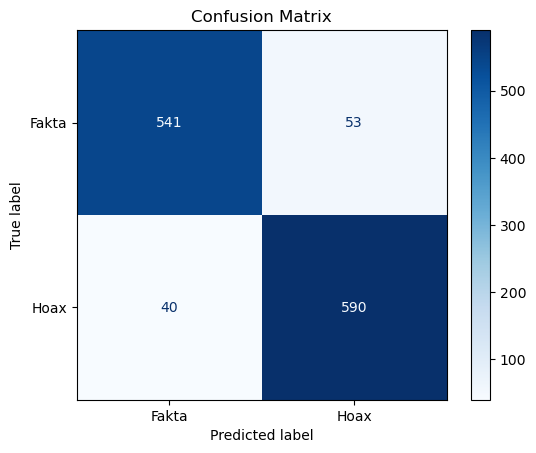

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions for the test dataset
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fakta", "Hoax"])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

plt.savefig("../hasil/confusion_matrix.png")

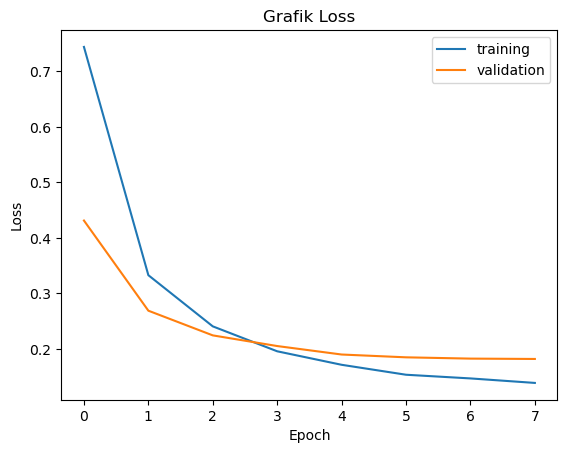

In [ ]:
plt.figure()
plt.plot(metrics['train_loss'], label="training")
plt.plot(metrics['val_loss'], label="validation")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Grafik Loss')
plt.legend()

plt.savefig("../hasil/grafik_loss.png")

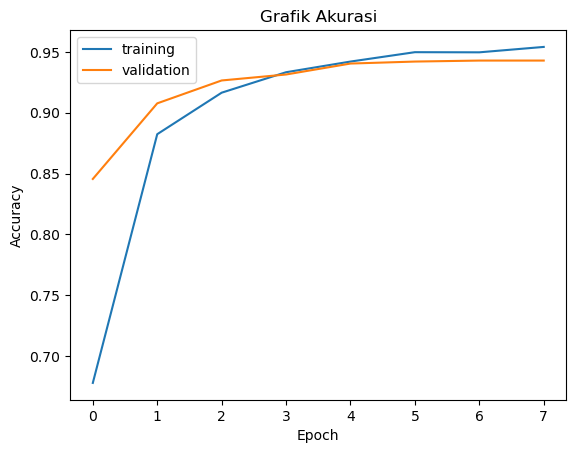

In [25]:
plt.figure()
plt.plot(metrics['train_acc'], label="training")
plt.plot(metrics['val_acc'], label="validation")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Grafik Akurasi')
plt.legend()

plt.savefig("../hasil/grafik_acc.png")

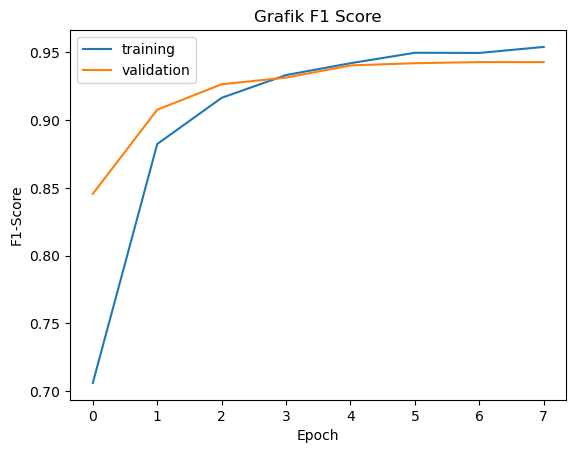

In [26]:
plt.figure()
plt.plot(metrics['train_f1'], label="training")
plt.plot(metrics['val_acc'], label="validation")
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Grafik F1 Score')
plt.legend()

plt.savefig("../hasil/grafik_f1.png")

In [23]:
tabel_hasil = pd.DataFrame(range(1, 9), columns=['ke-'])
tabel_hasil["loss_training"] = metrics["train_loss"]
tabel_hasil["loss_validation"] = metrics["val_loss"]
tabel_hasil["accuracy_training"] = metrics["train_acc"]
tabel_hasil["accuracy_validation"] = metrics["val_acc"]
tabel_hasil["F1-Score_training"] = metrics["train_f1"]
tabel_hasil["F1-Score_validation"] = metrics["val_f1"]

# Add testing metrics in the 9th row
testing_metrics = {
    "ke-": None,
    "loss_training": None,
    "loss_validation": None,
    "accuracy_training": None,
    "accuracy_validation": None,
    "F1-Score_training": None,
    "F1-Score_validation": None,
    "loss_testing": metrics["test_loss"],
    "accuracy_testing": metrics["test_acc"],
    "F1-Score_testing": metrics["test_f1"]
}
tabel_hasil = pd.concat([tabel_hasil, pd.DataFrame([testing_metrics])], ignore_index=True)
tabel_hasil.head()

tabel_hasil.to_excel("../model/model_IndoBERT.xlsx", index=False)

C:\Users\screm\AppData\Local\Temp\ipykernel_8120\3653877729.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabel_hasil = pd.concat([tabel_hasil, pd.DataFrame([testing_metrics])], ignore_index=True)


In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification

# Load the fine-tuned model
def load_model(model_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Tokenize the input text
def tokenize_text(text, tokenizer):
    return tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Make predictions
def predict(model, tokenizer, text):
    tokens = tokenize_text(text, tokenizer)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokens = {key: val.to(device) for key, val in tokens.items()}
    with torch.no_grad():
        outputs = model(**tokens)
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
    pred_label = np.argmax(probs, axis=1)
    return pred_label, probs

# Example usage
model_path = "../model/indobertModel.pt"
model = load_model(model_path)
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prediction: Hoax, Probability: 0.8006


In [11]:
text = "Gus Miftah Berbagi Bantuan, Permintaan Maaf ke Masyarakat"
pred_label, probs = predict(model, tokenizer, text)
label_map = {0: "Fakta", 1: "Hoax"}
predicted_label = label_map[pred_label[0]]
predicted_prob = probs[0][pred_label[0]]
print(f"Prediction: {predicted_label}, Probability: {predicted_prob:.4f}")

Prediction: Hoax, Probability: 0.9755
